In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install kiwipiepy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install konlpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd

C:\Users\cmhcm\AppData\Local\Temp\ipykernel_9524\1662815981.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 14781개 뉴스 데이터 가져오기
- 풀본문 있는 데이터 입니다.

In [6]:
data_path = "C:/dev/openAI/result_df_14761.csv"
df = pd.read_csv(data_path, dtype=str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14761 entries, 0 to 14760
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   news_id       14761 non-null  object
 1   news_date     14761 non-null  object
 2   news_keyword  14761 non-null  object
 3   news_feature  14761 non-null  object
 4   news_url      14686 non-null  object
 5   news_content  14761 non-null  object
 6   img_url       13992 non-null  object
dtypes: object(7)
memory usage: 807.4+ KB


# 중복제거 로직
- 형태소 분석기: Okt
- 벡터화: CountVectorizer
- 중복 기준: news_content 컬럼 데이터

In [7]:
from konlpy.tag import Okt

# 형태소 분석기 초기화
okt = Okt()

In [8]:
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

# 전처리 함수 정의
def tokenizer(raw, pos=["Noun", "Alpha", "Number"], stopword=[]):
    return [
        word for word, tag in okt.pos(
            raw,
            norm=True,
            stem=True
            )
            if len(word) > 1 and tag in pos and word not in stopword
        ]

## 전처리 및 벡터화

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorize = CountVectorizer(
    tokenizer=tokenizer,
    min_df=2
)

In [10]:
# 기사 본문에 나오는 단어의 빈도 계산
X = vectorize.fit_transform(df['news_content'])

c:\Users\cmhcm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [11]:
from sklearn.metrics.pairwise import cosine_similarity

# 코사인 유사도 계산
cos_sim = cosine_similarity(X)

# 코사인 유사도가 0.9 이상인 경우를 중복으로 판단
dup_idx = np.where(cos_sim > 0.9)

In [12]:
# 중복 기사 인덱스와 제목 출력 및 중복 기사 제거
to_drop = []

for i in range(len(dup_idx[0])):
    if dup_idx[0][i] != dup_idx[1][i]:  # 자기 자신과의 유사도는 제외

        # 먼저 게시된 기사를 남기고 싶으므로 인덱스가 더 작은 행을 제거
        to_remove = min(dup_idx[0][i], dup_idx[1][i])
        # print("삭제되는 기사 제목: ", df.iloc[to_remove]['news_id'])
        # print()

        to_drop.append(to_remove)

# 중복 기사 제거
df = df.drop(to_drop)
# 인덱스 재설정
df = df.reset_index(drop=True)

### 4,353개의 중복기사 제거

In [13]:
# 중복제거 확인
df.shape

(10429, 7)

# 전처리

### news_url: null일 경우 삭제

In [14]:
# url컬럼이 null 값을 가진 행 삭제
# df = df.dropna(subset=['news_url'])

### news_content: 명사/알파벳/숫자 추출
- tokenizer 함수는 중복제거 단계에서 정의함
- news_content 컬럼은 OpneAI에서 사용하기 때문에 삭제하면 안됨

In [15]:
preprocessed_text = df['news_content'].apply(lambda x: ' '.join(tokenizer(x)))
df['summery_content'] = preprocessed_text

### 불용어 정의 및 제거

In [16]:
# 먼저 두 컬럼을 각각 리스트로 변환합니다.
news_feature_list = df['news_feature'].str.split(',').tolist()
news_keyword_list = df['news_keyword'].str.split(',').tolist()

# 두 리스트를 합칩니다.
total_list = news_feature_list + news_keyword_list

# 리스트의 리스트를 하나의 리스트로 변환합니다.
flat_list = [item for sublist in total_list for item in sublist]

# 리스트를 문자열로 변환하고, 각 단어 사이에 ','를 넣습니다.
wordbook = ','.join(flat_list)

In [17]:
import collections

# 문자열을 다시 리스트로 변환합니다.
wordbook_list = wordbook.split(',')

# 가장 많이 등장하는 단어를 찾습니다.
word_counts = collections.Counter(wordbook_list)

# 가장 빈번하게 등장하는 단어 상위 20개를 출력합니다.
for word, count in word_counts.most_common(20):
    print(word, ": ", count)

브랜드 :  23783
팝업스토어 :  21292
팝업 :  19880
스토어 :  16792
서울 :  13103
진행 :  12552
운영 :  11294
제품 :  11110
판매 :  9903
상품 :  9896
매장 :  9815
고객 :  8898
행사 :  8842
공간 :  8391
제공 :  7300
대표 :  7169
오픈 :  6657
인기 :  6652
구매 :  6650
시장 :  6274


In [18]:
# 빈번하게 등장하는 단어 + 육안으로 검토했을 당시 필요없는 단어들 포함
stopwords = ['브랜드', '팝업스토어', '팝업', '스토어', '서울', '진행', '운영', '제품', '판매', '상품', 
            '매장', '고객', '행사', '공간', '제공', '대표', '오픈', '인기', '구매', '시장', '오프라인', 
            '온라인', '매출', '관계자', '소비자', '한국', '출시', '백화점', '론칭', '대한민국']


In [19]:
def remove_stopwords(text, stopwords):
    words = text.split(',')
    filtered_words = [word for word in words if word not in stopwords]
    return ','.join(filtered_words)

df['news_feature'] = df['news_feature'].apply(lambda x: remove_stopwords(x, stopwords))
df['news_keyword'] = df['news_keyword'].apply(lambda x: remove_stopwords(x, stopwords))


### news_feature와 news_keyword: 고유명사 추출 후 제거
- 추출한 고유명사는 'NNP' 컬럼에 저장

In [20]:
# "kiwi"를 사용해서 형태소 분석
from itertools import product
from kiwipiepy import Kiwi
kiwi = Kiwi()

In [21]:
# 형태소 분석 및 고유명사 추출 함수 정의
def analyze_and_extract_NNP(text):
    result = kiwi.analyze(text)
    NNP_words = [word for word, tag, _, _ in result[0][0] if tag == 'NNP']
    return NNP_words

In [22]:
# 쉼표 제거
df['news_feature'] = df['news_feature'].str.replace(',', ' ')
df['news_keyword'] = df['news_keyword'].str.replace(',', ' ') 

In [23]:
# news_feature와 news_keyword 열에 대해 고유명사 추출
df['NNP'] = df['news_feature'].apply(analyze_and_extract_NNP)
df['NNP'] = df['NNP'] + df['news_keyword'].apply(analyze_and_extract_NNP)

In [24]:
def clean_column(df, column_name, nnp_list):
    for index, row in df.iterrows():
        column_data = row[column_name]
        cleaned_data = ' '.join(word for word in column_data.split() if word not in nnp_list)
        df.at[index, f'{column_name}_cleaned'] = cleaned_data

    return df

In [25]:
# 'news_feature' 열 데이터와 'NNP' 열 데이터 비교하여 겹칠 경우 삭제
df = clean_column(df, 'news_feature', df['NNP'])

# 'news_keyword' 열 데이터와 'NNP' 열 데이터 비교하여 겹칠 경우 삭제
df = clean_column(df, 'news_keyword', df['NNP'])

# 군집화: K-means
### FastText 이용하여 벡터화

In [26]:
from gensim.models.fasttext import load_facebook_model

# FastText 모델 로드
ko_model = load_facebook_model("C:/Users/cmhcm/OneDrive/바탕 화면/cc.ko.300.bin")

In [27]:
# 데이터 프레임에서 텍스트 데이터를 가져옵니다.
feature_word = df['news_feature_cleaned'].values
keywords_word = df['news_keyword_cleaned'].values
content_word = df['summery_content'].values


# 세 단어장을 결합합니다.
combined_data = np.concatenate((feature_word, keywords_word, content_word))

In [28]:
# 텍스트를 단어 리스트로 변환하되, 중복되는 단어는 제거합니다.
word_lists = [list(set(text.split())) for text in combined_data]

# FastText 모델에 데이터를 추가 학습시킵니다.
ko_model.build_vocab(word_lists, update=True)
ko_model.train(word_lists, total_examples=len(word_lists), epochs=ko_model.epochs)

(1179564, 2761831)

In [29]:
# FastText 벡터화를 수행합니다.
vectors = []
for text in feature_word:
    words = [word for word in text.split() if word in ko_model.wv]
    if words:
        vector = np.mean([ko_model.wv[word] for word in words], axis=0)
    else:
        vector = np.zeros(ko_model.vector_size)  # 모델의 벡터 크기에 맞는 제로 벡터를 사용
    vectors.append(vector)

vectors = np.array(vectors)  # 벡터 리스트를 numpy array로 변환
vectors_clustering = vectors.copy()


In [30]:
from sklearn.cluster import KMeans

# 데이터프레임의 행의 수를 가져오는 코드 예시
n = len(df)  # df는 데이터프레임 변수명에 맞게 수정해야 합니다.

k = 5
# KMeans 모델 정의(K-means++로 개선해봄)
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0)


# FastText 값에 KMeans 모델 적용
kmeans.fit(vectors_clustering)

# 군집 결과를 '군집' 컬럼에 저장
df['군집'] = kmeans.labels_

In [31]:
df['군집'].value_counts()

군집
0    3014
2    2765
1    2199
3    1518
4     933
Name: count, dtype: int64

# ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
- '별'로 가둔 구간은 시각화 작업이며 실제 분석에는 영향을 미치지 않습니다.
- 클러스터링을 다양하게 해가며 군집의 중심을 체크
- 각 중심부의 데이터 100개를 추출해 군집의 특성을 파악하려 했으나 현재까진 인사이트가 도출되지 않습니다. 

## 군집 시각화

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random

In [33]:
# PCA 모델 생성 및 학습
pca = PCA(n_components=2)
pca_result = pca.fit_transform(vectors_clustering)

# PCA 결과를 데이터프레임에 추가
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

# KMeans 모델의 군집 중심점을 PCA 변환
centroids_pca = pca.transform(kmeans.cluster_centers_)


C:\Users\cmhcm\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44400 (\N{HANGUL SYLLABLE GUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cmhcm\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51665 (\N{HANGUL SYLLABLE JIB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cmhcm\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cmhcm\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49900 (\N{HANGUL SYLLABLE SIM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


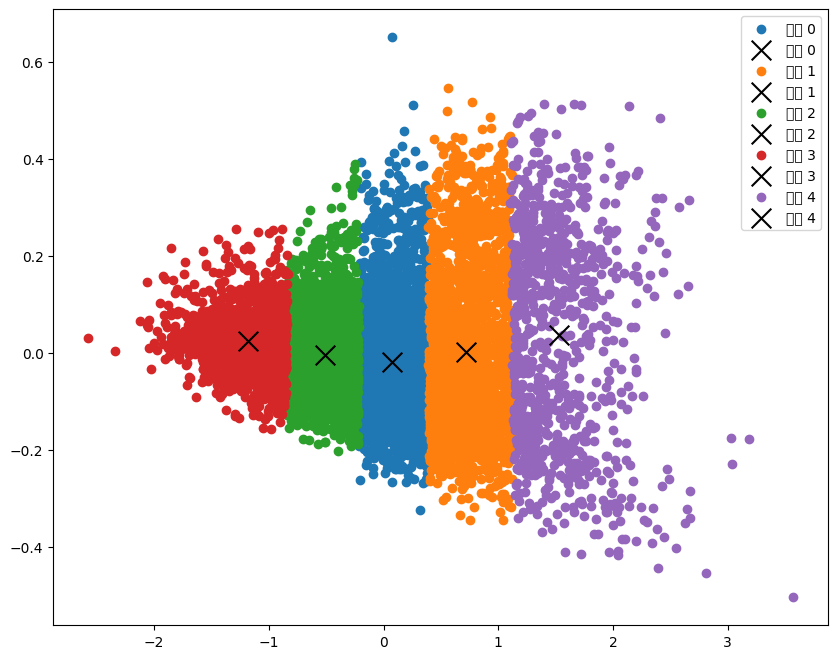

In [34]:
# 각 군집의 데이터와 중심을 시각화
plt.figure(figsize=(10, 8))
for i in range(k):
    plt.scatter(df[df['군집'] == i]['PCA1'], df[df['군집'] == i]['PCA2'], label='군집 '+str(i))
    plt.scatter(centroids_pca[i, 0], centroids_pca[i, 1], label='중심 '+str(i), marker='x', s=200, c='black')
plt.legend()
plt.show()

In [35]:
from sklearn.neighbors import NearestNeighbors

# 각 군집의 중심점에서 가장 가까운 100개의 데이터를 찾음
nearest_points = []
for i in range(k):
    # 해당 군집의 데이터를 선택
    cluster_points = df[df['군집'] == i][['PCA1', 'PCA2']].values

    # NearestNeighbors 모델 생성 및 학습
    nn = NearestNeighbors(n_neighbors=100)
    nn.fit(cluster_points)

    # 군집의 중심점에서 가장 가까운 데이터의 인덱스를 찾음
    distances, indices = nn.kneighbors([centroids_pca[i]])

    # 가장 가까운 데이터를 선택
    nearest_points.append(df.iloc[indices[0]])

In [36]:
# 가장 가까운 데이터를 합침
nearest_points_df = pd.concat(nearest_points)

### 각 군집의 핵심 단어 추출 후 .txt 파일로 저장
- 주피터 내에서 보기엔 너무 불편함으로 파일로 저장 후 확인하는 것을 선택했습니다.

In [37]:
import collections

with open('kmeans_output1.txt', 'w', encoding='utf-8') as f:
    for i in range(k):
        f.write(f"군집 {i}:\n")

        for column in ['news_keyword', 'news_feature']:
            f.write(f"{column}에서 가장 많이 등장하는 단어 상위 5개:\n")

            # 해당 군집에서 해당 컬럼의 데이터를 모두 합칩니다.
            text = ','.join(nearest_points_df[nearest_points_df['군집'] == i][column])

            # 문자열을 단어로 분리합니다.
            words = text.split()

            # 가장 많이 등장하는 단어를 찾습니다.
            word_counts = collections.Counter(words)

            # 가장 빈번하게 등장하는 단어 상위 5개를 출력합니다.
            for word, count in word_counts.most_common(5):
                f.write(f"{word} : {count}\n")
            f.write("\n")

# ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨

# 사용자 데이터셋 만들기

## H&M 데이터셋

In [58]:
df_article = pd.read_csv("C:/Users/cmhcm/OneDrive/바탕 화면/H&M_dataset/articles.csv", dtype=str)
df_transactions = pd.read_csv("C:/Users/cmhcm/OneDrive/바탕 화면/H&M_dataset/transactions_train.csv", dtype=str)

In [59]:
df_article = df_article[['article_id', 'index_group_name']]
df_transactions = df_transactions[['t_dat', 'customer_id', 'article_id']]

In [60]:
# 모든 고객과 모든 상품그룹의 조합을 생성합니다.
customers = df_transactions['customer_id'].unique()
groups = df_article['index_group_name'].unique()
all_combinations = pd.MultiIndex.from_product([customers, groups], names=['customer_id', 'index_group_name']).to_frame(index=False)

# 두 데이터프레임을 'article_id'를 기준으로 merge합니다.
merged_df = pd.merge(df_transactions, df_article, on='article_id', how='left')

# 각 고객이 구매한 상품그룹의 수를 계산합니다.
purchase_df = merged_df.groupby(['customer_id', 'index_group_name']).size().reset_index(name='count')

# 모든 고객과 상품그룹의 조합과 구매 데이터를 병합합니다.
# 이때, 구매하지 않은 상품그룹은 NaN으로 표시되므로 이를 0으로 치환합니다.
final_df = pd.merge(all_combinations, purchase_df, on=['customer_id', 'index_group_name'], how='left').fillna(0)


In [61]:
# 각 고객의 전체 구매 횟수를 계산합니다.
total_counts = final_df.groupby('customer_id')['count'].sum()

# 'ratio' 컬럼을 추가합니다. 이 컬럼은 각 상품 그룹의 구매 횟수를 전체 구매 횟수로 나눈 값입니다.
final_df['ratio'] = final_df.apply(lambda row: row['count'] / total_counts[row['customer_id']], axis=1)

# 'ratio' 컬럼의 값을 소수점 세 자리까지만 나타냅니다.
final_df['ratio'] = final_df['ratio'].round(3)

In [62]:
# count 컬럼은 삭제
# 원본 데이터프레임 유지를 위해 updated_final_df 새로 생성
updated_final_df = final_df.drop(columns=['count'])

In [85]:
# updated_final_df에서 3000000번째 행 이후의 모든 행 삭제 (원본 데이터프레임을 변경)
updated_final_df.drop(range(3000000, len(updated_final_df)), inplace=True)

In [86]:
updated_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       50000 non-null  object 
 1   index_group_name  50000 non-null  object 
 2   ratio             50000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


## 데이터프레임 합치기

In [87]:
# 이름을 바꿀 딕셔너리 생성
name_mapping = {
    'Ladieswear': 3,
    'Divided': 4,
    'Baby/Children': 1,
    'Menswear': 0,
    'Sport': 2
}

# 'index_group_name' 컬럼의 값을 변경
updated_final_df['index_group_name'] = updated_final_df['index_group_name'].replace(name_mapping)

In [66]:
# 'PCA1', 'PCA2', 'news_keyword', 'news_feature' 열을 삭제하여 새로운 DataFrame을 생성
updated_df = df.drop(columns=['PCA1', 'PCA2', 'news_keyword', 'news_feature'])

In [67]:
# null 값을 가진 행을 삭제한 새로운 DataFrame 생성
updated_df = updated_df.dropna()

In [88]:
updated_df['군집'] = updated_df['군집'].astype(str)
updated_final_df['index_group_name'] = updated_final_df['index_group_name'].astype(str)

In [89]:
merged_df = pd.merge(updated_df, updated_final_df, left_on='군집', right_on='index_group_name', how='inner')

MemoryError: Unable to allocate 2.19 GiB for an array with shape (3, 97760000) and data type object

In [ ]:
merged_df

,news_id,news_date,news_url,news_content,img_url,summery_content,NNP,news_feature_cleaned,news_keyword_cleaned,군집,customer_id,index_group_name,ratio


In [ ]:
print(updated_df['군집'].unique())
print(updated_final_df['index_group_name'].unique())


['2' '1' '3' '0' '4']
[3 1 0 2 4]
